# Pnemonia Capstone

The purpose of this project is 'object detection'. Our model should be able to detect the areas of the lung which shows signs of pnemonia.
Generally, object detection algorithms with deep learning take a long time to train model and require a lot of gpu resources, such as UNet, VGG algorithms.
In comparison to YOLOv3, Other algorithms(VGG, UNet, ...) which contain instance/sementic segmentation tasks are very slow, and require more gpu resources, redundant parameter tunning and post-processes. Therefore, if you try to use these algorithms, you may experience difficulties in terms of training time and gpu resources. (Please see YOLOv3 paper for details)
In addition, YOLOv3 was able to obtain high score (LB: 0.141) without additional processes(data augmentation, parameter tunning, etc...) compared to other algorithms.

Mount google drive to read the data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Installing required python modules in google colab and Importing required modules

In [2]:
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

     |████████████████████████████████| 35.3MB 123kB/s 


In [3]:
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pydicom
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pwd

'/content'

Changing the directory to the correct folder

In [4]:
cd /content/drive/My\ Drive/Colab\ Notebooks/RSNAContent

/content/drive/My Drive/Colab Notebooks/RSNAContent


In [6]:
cd ./rsna

/content/drive/My Drive/Colab Notebooks/RSNAContent/rsna/rsna


Initializing the random_stat variable to randomly read data from pandas

In [0]:
random_stat = 123
np.random.seed(random_stat)

Install/Clone the darknet module, which has most used implementation of YOLO model with pretrained weights. This will help achieve better results especially in scenarios where the computation is limited.

In [ ]:
!git clone https://github.com/pjreddie/darknet.git

Using the Makefile command, we are creating a file to utilise the CPU instead of GPU, as i couldnt find any cudo cores in google colab.

In [0]:
!cd darknet && sed '1 s/^.*$/OPENMP=1/' -i Makefile
!cd darknet && make -j 50 -s
!cp darknet/darknet darknet_cpu

!chmod 755 darknet_cpu
!chmod 755 metadata/tr_list.txt

'/content/drive/My Drive/Colab Notebooks/RSNAContent/rsna/rsna'

Creating and configuring folders for storing the traning data, config file and trained models.
Images stores all the converted dicom files.
Labels will store the other data like bounding box, labels etc.
metadata will store the list of file to be processed. training list, test list and validation list.

In [0]:
train_dcm_dir = os.path.join("/content/drive/My\ Drive/Colab\ Notebooks", "stage_2_train_images")
test_dcm_dir = os.path.join( "/content/drive/My\ Drive/Colab\ Notebooks","stage_2_test_images")

img_dir = os.path.join("images")  # .jpg
label_dir = os.path.join("labels")  # .txt
metadata_dir = os.path.join("metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join("cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join("backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [0]:
!ls -shtl

total 318M
 512 -rw------- 1 root root   14 Apr 15 06:14 train1_log.txt
 512 -rw------- 1 root root   14 Apr 15 06:12 train_log.txt
1.5M -rw------- 1 root root 1.5M Apr 14 18:23 stage_2_train_labels.csv
1.6M -rw------- 1 root root 1.6M Apr 14 18:23 stage_2_detailed_class_info.csv
4.0K drwx------ 2 root root 4.0K Apr 12 20:00 backup
155M -rw------- 1 root root 155M Apr 12 20:00 darknet53.conv.74.1
715K -rw------- 1 root root 715K Apr 12 20:00 darknet_cpu
1.9M -rw------- 1 root root 1.9M Apr 12 20:00 darknet_gpu
4.0K drwx------ 2 root root 4.0K Apr 12 20:00 cfg
4.0K drwx------ 2 root root 4.0K Apr 12 20:00 metadata
4.0K drwx------ 2 root root 4.0K Apr 12 19:59 labels
1.9M -rw------- 1 root root 1.9M Apr 12 19:19 darknet_gpu1
4.0K drwx------ 2 root root 4.0K Apr 12 19:19 images
4.0K drwx------ 2 root root 4.0K Apr 12 19:15 darknet
155M -rw------- 1 root root 155M Apr 12 19:15 darknet53.conv.74


In [12]:
annots = pd.read_csv(os.path.join("stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
        
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue

        target = row[5]
        # Since kaggle kernel have samll volume (5GB ?), I didn't contain files with no bbox here.
        if target == 0:
            continue
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

Using the above functions, all the dicom data is converted to jpg, to be used as input to the yolo model.

In [0]:
!du -sh images labels

1.5G	images
3.0M	labels


Sample images , which shows the pnemonia affected lung with its bounding boxs

ex_img_path  images/00436515-870c-4b36-a041-de91049b9ab4.jpg
0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



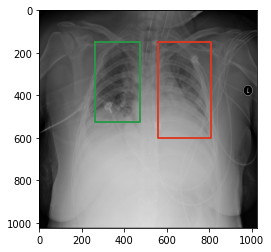

In [15]:
ex_patient_id = annots[annots.Target == 1].patientId.values[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))
print("ex_img_path ",ex_img_path)
plt.imshow(cv2.imread(ex_img_path))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [0]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [0]:
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5410, The # of validation set: 602


Creates test data- Shows the test data with no bounding boxes.

In [ ]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [ ]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)

In [ ]:
ex_patient_id = test_dcm_fps[0]
ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))

plt.imshow(cv2.imread(ex_img_path))

 cfg/rsna.data
 cfg/rsna.names
 darknet53.conv.74
 cfg/rsna_yolov3.cfg_train

In [0]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
valid  = {}
names  = {}
backup = {}
train  = {}
    """.format(os.path.join(metadata_dir, 'val_list.txt'),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir,
               os.path.join(metadata_dir, 'tr_list.txt'))
    f.write(contents)

In [0]:
!cat cfg/rsna.data

classes= 1
valid  = metadata/val_list.txt
names  = cfg/rsna.names
backup = backup
train  = metadata/tr_list.txt
    

In [0]:
!chmod 755 *.*
!chmod 755 darknet_cpu
!chmod 755 cfg/rsna_yolov3b2.cfg_train

Like discussed above the pre-trained weights and config file are taken from the darknet implementation

In [0]:
!wget -q https://pjreddie.com/media/files/darknet53.conv.74

In [ ]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=18ptTK4Vbeokqpux8Onr0OmwUP9ipmcYO" -O cfg/rsna_yolov3.cfg_train

Below are series of commands to mount a virtual drive with a shorter path without spaces in the path. Model was failed to read the config files because of spaces between My Drive and Colab Notebooks. Special characters are not read and spaces were truncated automatically.

In [ ]:
!cp -r "/content/drive/My Drive/Colab Notebooks/RSNAContent" ./rsna

In [ ]:
!chmod 755 darknet_gpu
!chmod 755 darknet53.conv.74
!chmod 755 /content/drive/My\ Drive/Colab\ Notebooks/RSNAContent

Training the model using the preconfigured weights

In [0]:
! ./darknet_cpu detector train cfg/rsna.data cfg/rsna_yolov3b1.cfg_train darknet53.conv.74 -i 0 | tee train1_log.txt
#!./darknet detector train "/content/gdrive/My Drive/darknet/obj.data" "/content/gdrive/My Drive/darknet/yolov3.cfg" "/content/gdrive/My Drive/darknet/darknet53.conv.74" -dont_show 

Streaming output truncated to the last 5000 lines.
Loaded: 0.000063 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003751, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.678754, Class: 0.551234, Obj: 0.001797, No Obj: 0.001713, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000700, .5R: -nan, .75R: -nan,  count: 0
355: 0.691688, 3.816765 avg, 0.000016 rate, 18.955095 seconds, 355 images
Loaded: 0.000090 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003502, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.245192, Class: 0.521412, Obj: 0.001725, No Obj: 0.001699, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000703, .5R: -nan, .75R: -nan,  count: 0
356: 7.542605, 4.189349 avg, 0.000016 rate, 19.016553 seconds, 356 images
Loaded: 0.000064 seconds
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003579, .5R: -nan, .75R: 

In [0]:
!chmod 755 *.*
!chmod 755 darknet_cpu
!chmod 755 cfg/rsna_yolov3b2.cfg_train
!chmod 755 rsna_yolov3.cfg_test
!chmod 755 rsna_yolov3_15300.weights

! ./darknet_cpu detector train cfg/rsna.data cfg/rsna_yolov3b1.cfg_train darknet53.conv.74 -i 0 | tee train1_log.txt

!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_train ../backup/rsna_yolov3_15300.weights ../test.jpg -thresh 0.005

In [0]:
!chmod 755 darknet/darknet

In [0]:
!chmod 755 test.jpg
!chmod 755 images/*.*

In [0]:
!chmod 755 backup/rsna_yolov3b1_900.weights
!chmod 755 backup/rsna_yolov3_15300.weights
!chmod 755 backup/*.*

!cd darknet && ./darknet detector test ../cfg/rsna.data ../backup/rsna_yolov3.cfg_test ../rsna_yolov3_15300.weights ../test.jpg -thresh 0.005

Tested sample using the trained model, using only 900 samples and prediction was pretty bad, while the trained model with 15000 sample showed better results.

In [22]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../rsna_yolov3.cfg_test ../backup/rsna_yolov3b2_900.weights ../images/00436515-870c-4b36-a041-de91049b9ab4.jpg -thresh 0.005

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [27]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../rsna_yolov3.cfg_test ../backup/rsna_yolov3_15300.weights ../images/00436515-870c-4b36-a041-de91049b9ab4.jpg -thresh 0.005

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Actual image with bounding boxs


0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



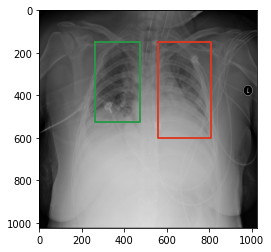

In [16]:
plt.imshow(cv2.imread("images/00436515-870c-4b36-a041-de91049b9ab4.jpg"))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

Prediction : 900 and 15000 weights respectively

Using the lesser weights resulted in bounding boxs all over the image. 

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



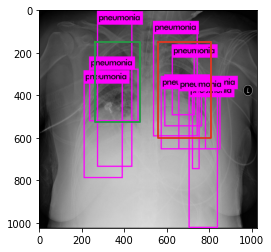

In [26]:
plt.imshow(cv2.imread("darknet/predictions_900N.jpg"))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

This images shows lesser bounding boxes, but still not as expected from the provided data. 

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875

0 0.673828125 0.36962890625 0.25 0.4423828125



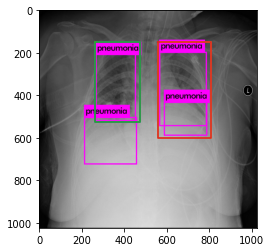

In [28]:
plt.imshow(cv2.imread("darknet/predictions.jpg"))

img_size = 1014
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

Over all the yolo was able to make good predictions, when the training data is increased. 